In [16]:
!pip install seaborn
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 171.6 kB/s  0:00:09 eta 0:00:01

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [18]:
!pip install numpy pandas scikit-learn imbalanced-learn matplotlib torch torchvision pytorch-tabnet xgboost joblib


Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.8.0-cp39-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl.metadata (15 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 14.6 MB/s  0:00:05 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 22.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 9.9 MB/s  0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [22]:
# ✅ Install all dependencies (Colab already has CUDA & libomp)
!pip install numpy pandas scikit-learn imbalanced-learn matplotlib torch torchvision pytorch-tabnet xgboost joblib


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [25]:
!pip install numpy pandas scikit-learn imbalanced-learn matplotlib torch torchvision pytorch-tabnet joblib


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [36]:
pip install rtdl


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
pip install pytorch-tabnet


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
import os
import warnings
import itertools
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

warnings.filterwarnings("ignore")

# Try XGBoost
try:
    import xgboost as xgb
    xgb_available = True
except Exception as e:
    print("⚠️ XGBoost not available, skipping. Reason:", e)
    xgb_available = False

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier


# =============================================
# DEVICE INFO
# =============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n📟 Device Info:")
print(" Torch version:", torch.__version__)
print(" CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(" GPU:", torch.cuda.get_device_name(0))


# =============================================
# LOAD DATASET
# =============================================
df = pd.read_csv("wdbc.data", header=None)
cols = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df.columns = cols

df.drop("id", axis=1, inplace=True)
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

print("\nOriginal class balance:\n", y.value_counts(), "\n")


# =============================================
# PREPROCESSING
# =============================================
robust = RobustScaler()
Xr = robust.fit_transform(X)

scaler = StandardScaler()
Xs = scaler.fit_transform(Xr)

# Select K Best = 10
selector = SelectKBest(score_func=f_classif, k=10)
Xs_k = selector.fit_transform(Xs, y)

selected = X.columns[selector.get_support()]
print("Top 10 Selected Features:\n", selected.tolist(), "\n")

# SMOTE
sm = SMOTE(random_state=42)
Xb, yb = sm.fit_resample(Xs_k, y)

print("Balanced class distribution:\n", pd.Series(yb).value_counts(), "\n")

# Train / Test
Xtr, Xte, ytr, yte = train_test_split(
    Xb, yb, test_size=0.2, stratify=yb, random_state=42
)

# =============================================
# SAVE PREPROCESSING VISUALIZATIONS
# =============================================
os.makedirs("results", exist_ok=True)

plt.figure(figsize=(8, 4))
plt.plot(pd.DataFrame(Xr).median().values)
plt.title("Feature Medians after RobustScaler")
plt.savefig("results/feature_medians.png")
plt.close()

plt.imshow(pd.DataFrame(Xs_k, columns=selected).corr(), aspect='auto')
plt.colorbar()
plt.title("Selected Feature Correlation Heatmap")
plt.savefig("results/selected_corr.png")
plt.close()


# =============================================
# HELPER FUNCTIONS
# =============================================
def plot_cm(cm, name):
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, cm[i, j],
            ha="center",
            color="white" if cm[i, j] > cm.max() / 2 else "black"
        )

    plt.tight_layout()
    plt.savefig(f"results/cm_{name}.png")
    plt.close()


def evaluate(model, name, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    proba = (
        model.predict_proba(Xte)[:, 1]
        if hasattr(model, "predict_proba")
        else model.decision_function(Xte)
    )

    preds = (proba >= 0.5).astype(int)

    return dict(
        acc=accuracy_score(yte, preds),
        prec=precision_score(yte, preds),
        rec=recall_score(yte, preds),
        f1=f1_score(yte, preds),
        auc=roc_auc_score(yte, proba),
        cm=confusion_matrix(yte, preds),
        proba=proba
    )


def save_roc(data):
    plt.figure(figsize=(6, 5))
    for n, (fpr, tpr, a) in data.items():
        plt.plot(fpr, tpr, label=f"{n} (AUC={a:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curves")
    plt.savefig("results/roc_all.png")
    plt.close()


# =============================================
# BASELINE ML MODELS
# =============================================
print("Training ML Baselines...\n")

results = {}

baselines = [
    ("LogReg", LogisticRegression(max_iter=2000)),
    ("RF", RandomForestClassifier(n_estimators=200, random_state=42)),
    ("SVM", SVC(probability=True))
]

if xgb_available:
    baselines.append(("XGBoost", xgb.XGBClassifier(
        eval_metric='logloss', use_label_encoder=False
    )))

for name, model in baselines:
    r = evaluate(model, name, Xtr, ytr, Xte, yte)
    results[name] = r
    print(f"{name}: acc={r['acc']:.3f}, auc={r['auc']:.3f}")


# =============================================
# MLP MODEL
# =============================================
class MLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


def train_torch(model, loader, epochs=30, lr=1e-3):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for e in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()

        if (e + 1) % 10 == 0:
            print(f"Epoch {e+1}/{epochs}")


def pred_proba(model, X):
    model.eval()
    with torch.no_grad():
        xb = torch.tensor(X, dtype=torch.float32).to(device)
        logits = model(xb).cpu().numpy().ravel()
    return 1 / (1 + np.exp(-logits))


ytr = np.array(ytr)
yte = np.array(yte)

Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
ytr_t = torch.tensor(ytr.reshape(-1, 1), dtype=torch.float32)

dl = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)

mlp = MLP(Xtr.shape[1])
train_torch(mlp, dl, epochs=40)

proba_mlp = pred_proba(mlp, Xte)
pred = (proba_mlp >= 0.5).astype(int)

results["MLP"] = dict(
    acc=accuracy_score(yte, pred),
    prec=precision_score(yte, pred),
    rec=recall_score(yte, pred),
    f1=f1_score(yte, pred),
    auc=roc_auc_score(yte, proba_mlp),
    cm=confusion_matrix(yte, pred),
    proba=proba_mlp
)


# =============================================
# TABNET MODEL
# =============================================
print("\nTraining TabNet...")

tab = TabNetClassifier(seed=42, verbose=0)
tab.fit(
    Xtr, ytr,
    eval_set=[(Xte, yte)],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=64
)

proba_tab = tab.predict_proba(Xte)[:, 1]
pred = (proba_tab >= 0.5).astype(int)

results["TabNet"] = dict(
    acc=accuracy_score(yte, pred),
    prec=precision_score(yte, pred),
    rec=recall_score(yte, pred),
    f1=f1_score(yte, pred),
    auc=roc_auc_score(yte, proba_tab),
    cm=confusion_matrix(yte, pred),
    proba=proba_tab
)


# =============================================
# FT-TRANSFORMER
# =============================================
print("\nTraining FT-Transformer...")


class FTTransformer(nn.Module):
    def __init__(self, n, d=64, h=4, l=3, drop=0.1):
        super().__init__()
        self.proj = nn.Linear(1, d)

        enc = nn.TransformerEncoderLayer(d, h, d * 4, drop)
        self.encoder = nn.TransformerEncoder(enc, l)

        self.cls = nn.Parameter(torch.randn(1, 1, d))

        self.head = nn.Sequential(
            nn.LayerNorm(d),
            nn.Linear(d, 1)
        )

    def forward(self, x):
        b, n = x.shape
        tok = self.proj(x.unsqueeze(2))
        cls = self.cls.expand(b, -1, -1)

        seq = torch.cat([cls, tok], dim=1).permute(1, 0, 2)
        enc = self.encoder(seq)

        return self.head(enc[0])


ft = FTTransformer(Xtr.shape[1])
train_torch(ft, dl, epochs=50)

proba_ft = pred_proba(ft, Xte)
pred = (proba_ft >= 0.5).astype(int)

results["FT-Transformer"] = dict(
    acc=accuracy_score(yte, pred),
    prec=precision_score(yte, pred),
    rec=recall_score(yte, pred),
    f1=f1_score(yte, pred),
    auc=roc_auc_score(yte, proba_ft),
    cm=confusion_matrix(yte, pred),
    proba=proba_ft
)


# =============================================
# ENSEMBLE (MLP + TABNET)
# =============================================
proba_ens = (results["MLP"]["proba"] + results["TabNet"]["proba"]) / 2
pred_ens = (proba_ens >= 0.5).astype(int)

results["Ensemble_MLP_TabNet"] = dict(
    acc=accuracy_score(yte, pred_ens),
    prec=precision_score(yte, pred_ens),
    rec=recall_score(yte, pred_ens),
    f1=f1_score(yte, pred_ens),
    auc=roc_auc_score(yte, proba_ens),
    cm=confusion_matrix(yte, pred_ens),
    proba=proba_ens
)


# =============================================
# CREATE COMPARISON TABLE
# =============================================
roc_data = {}
rows = []

for n, r in results.items():
    rows.append([n, r["acc"], r["prec"], r["rec"], r["f1"], r["auc"]])
    fpr, tpr, _ = roc_curve(yte, r["proba"])
    roc_data[n] = (fpr, tpr, r["auc"])

    plot_cm(r["cm"], n)

df_results = pd.DataFrame(
    rows,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
).sort_values("AUC", ascending=False)

df_results.to_csv("results/model_comparison.csv", index=False)

print("\n=== MODEL COMPARISON TABLE ===\n")
print(df_results)

save_roc(roc_data)

plt.figure(figsize=(8, 5))
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
w = 0.15
x = np.arange(len(df_results))

for i, m in enumerate(metrics):
    plt.bar(x + i * w, df_results[m], width=w, label=m)

plt.xticks(x + w * 2, df_results["Model"], rotation=45, ha="right")
plt.legend()
plt.title("Model Metrics Comparison")
plt.tight_layout()
plt.savefig("results/metrics_bar.png")
plt.close()

print("\n✅ All results, plots, and images saved in /results/")



📟 Device Info:
 Torch version: 2.8.0
 CUDA available: False

Original class balance:
 0    357
1    212
Name: diagnosis, dtype: int64 

Top 10 Selected Features:
 ['feature_1', 'feature_3', 'feature_4', 'feature_7', 'feature_8', 'feature_21', 'feature_23', 'feature_24', 'feature_27', 'feature_28'] 

Balanced class distribution:
 1    357
0    357
Name: diagnosis, dtype: int64 

Training ML Baselines...

LogReg: acc=0.972, auc=0.998
RF: acc=0.979, auc=0.998
SVM: acc=0.979, auc=0.999
XGBoost: acc=0.972, auc=0.996
Epoch 10/40
Epoch 20/40
Epoch 30/40
Epoch 40/40

Training TabNet...

Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_auc = 0.99902

Training FT-Transformer...
Epoch 10/50
Epoch 20/50
Epoch 30/50
Epoch 40/50
Epoch 50/50

=== MODEL COMPARISON TABLE ===

                 Model  Accuracy  Precision    Recall        F1       AUC
7  Ensemble_MLP_TabNet  0.979021   0.985714  0.971831  0.978723  0.999218
5               TabNet  0.972028   0.958904  0.985915  0.9

DEVICE: cpu
Selected columns: ['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'compactness_mean' 'concavity_mean' 'concave_points_mean' 'radius_se'
 'perimeter_se' 'area_se' 'concave_points_se' 'radius_worst'
 'texture_worst' 'perimeter_worst' 'area_worst' 'smoothness_worst'
 'compactness_worst' 'concavity_worst' 'concave_points_worst'
 'symmetry_worst']
Training TabNet (pytorch-tabnet)...
epoch 0  | loss: 0.63579 | val_0_accuracy: 0.77622 |  0:00:00s


/Users/sowmith/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.4321  | val_0_accuracy: 0.91608 |  0:00:00s
epoch 2  | loss: 0.26002 | val_0_accuracy: 0.95105 |  0:00:00s
epoch 3  | loss: 0.1656  | val_0_accuracy: 0.95105 |  0:00:00s
epoch 4  | loss: 0.13302 | val_0_accuracy: 0.93706 |  0:00:00s
epoch 5  | loss: 0.12713 | val_0_accuracy: 0.95804 |  0:00:00s
epoch 6  | loss: 0.11695 | val_0_accuracy: 0.95105 |  0:00:00s
epoch 7  | loss: 0.14289 | val_0_accuracy: 0.95105 |  0:00:00s
epoch 8  | loss: 0.14547 | val_0_accuracy: 0.95105 |  0:00:00s
epoch 9  | loss: 0.09557 | val_0_accuracy: 0.96503 |  0:00:00s
epoch 10 | loss: 0.11312 | val_0_accuracy: 0.96503 |  0:00:01s
epoch 11 | loss: 0.08154 | val_0_accuracy: 0.97203 |  0:00:01s
epoch 12 | loss: 0.08123 | val_0_accuracy: 0.97902 |  0:00:01s
epoch 13 | loss: 0.05605 | val_0_accuracy: 0.97203 |  0:00:01s
epoch 14 | loss: 0.06734 | val_0_accuracy: 0.97203 |  0:00:01s
epoch 15 | loss: 0.06402 | val_0_accuracy: 0.96503 |  0:00:01s
epoch 16 | loss: 0.06529 | val_0_accuracy: 0.95105 |  0

/Users/sowmith/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MLP Epoch 31/100 train_loss=0.0228 val_loss=0.0708
MLP Epoch 41/100 train_loss=0.0126 val_loss=0.0764
MLP Epoch 51/100 train_loss=0.0085 val_loss=0.0942
MLP Epoch 61/100 train_loss=0.0087 val_loss=0.1023
MLP Epoch 71/100 train_loss=0.0061 val_loss=0.1260
MLP Epoch 81/100 train_loss=0.0042 val_loss=0.1332
MLP Epoch 91/100 train_loss=0.0029 val_loss=0.1109
MLP Epoch 100/100 train_loss=0.0023 val_loss=0.1047
MLP final acc: 0.972027972027972 f1: 0.9710144927536231


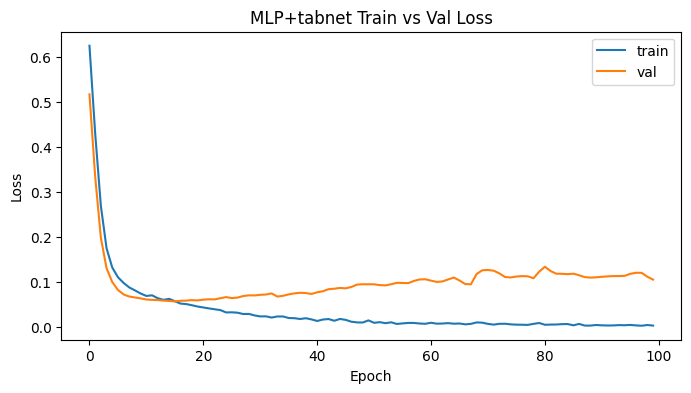

Training custom FT-Transformer...
FT Epoch 1/100 train_loss=0.4093 val_loss=0.0622
FT Epoch 11/100 train_loss=0.0653 val_loss=0.0686
FT Epoch 21/100 train_loss=0.0484 val_loss=0.1092
FT Epoch 31/100 train_loss=0.0390 val_loss=0.0605
FT Epoch 41/100 train_loss=0.0355 val_loss=0.0772
FT Epoch 51/100 train_loss=0.0118 val_loss=0.1852
FT Epoch 61/100 train_loss=0.0741 val_loss=0.3301
FT Epoch 71/100 train_loss=0.2227 val_loss=0.2177
FT Epoch 81/100 train_loss=0.3210 val_loss=0.4501
FT Epoch 91/100 train_loss=0.5671 val_loss=0.4986
FT Epoch 100/100 train_loss=0.3441 val_loss=0.3681
FT-Transformer final acc: 0.7972027972027972 f1: 0.7716535433070867


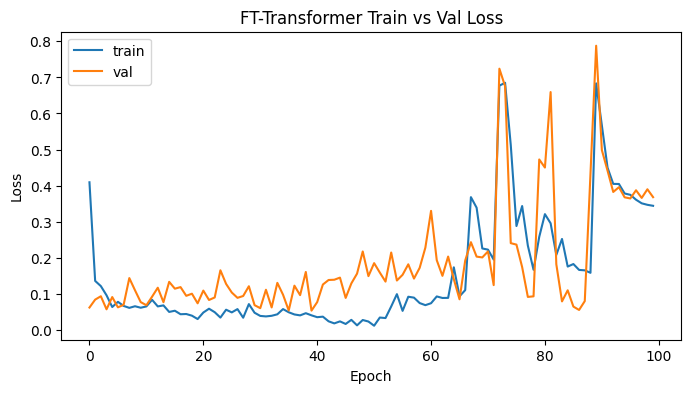

Ensemble (TabNet+MLP) acc: 0.972027972027972
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.94      0.97        71

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143


===== Final Metrics Summary =====
MLP accuracy: 0.972027972027972 f1: 0.9710144927536231
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.94      0.97        71

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

FT accuracy: 0.7972027972027972 f1: 0.7716535433070867
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        72
           1       0.88      0.69      0.77    

In [17]:
# train_all_models.py
import os
import sys
import time
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Optional TabNet import
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    _HAS_TABNET = True
except Exception:
    _HAS_TABNET = False

# ================
# Utilities
# ================
def load_and_clean(path="./wdbc.data"):
    # Load UCI wdbc.data
    df = pd.read_csv(path, header=None)
    columns = [
        'ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
        'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean',
        'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
        'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
        'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst',
        'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
        'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst',
        'fractal_dimension_worst'
    ]
    df.columns = columns
    df.drop('ID', axis=1, inplace=True)
    df['Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})
    df.rename(columns={'Diagnosis': 'diagnosis'}, inplace=True)
    return df

# reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", device)

# ================
# Preprocessing pipeline function
# ================
def preprocess_pipeline(df, k_features=20, test_size=0.2):
    X = df.drop(columns=["diagnosis"])
    y = df["diagnosis"].values

    # 1) Outlier handling with RobustScaler
    robust = RobustScaler()
    X_robust = robust.fit_transform(X)

    # 2) Z-score normalization
    zsc = StandardScaler()
    X_scaled = zsc.fit_transform(X_robust)

    # 3) SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_sel = selector.fit_transform(X_scaled, y)
    selected_cols = np.array(X.columns)[selector.get_support()]

    # 4) SMOTE
    smote = SMOTE(random_state=SEED)
    X_bal, y_bal = smote.fit_resample(X_sel, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=test_size, random_state=SEED, stratify=y_bal)

    # Return also pipeline pieces for later use
    pipeline = {
        "robust": robust,
        "zscaler": zsc,
        "selector": selector,
        "selected_cols": selected_cols
    }
    return X_train, X_test, y_train, y_test, pipeline

# ================
# PyTorch dataset helper
# ================
def make_torch_dataloaders(X_train, y_train, X_val=None, y_val=None, batch_size=64):
    Xtr = torch.tensor(X_train, dtype=torch.float32)
    ytr = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    train_ds = TensorDataset(Xtr, ytr)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    val_loader = None
    if X_val is not None:
        Xte = torch.tensor(X_val, dtype=torch.float32)
        yte = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
        val_loader = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# ================
# MLP (simple) model
# ================
class BaselineMLP(nn.Module):
    def __init__(self, in_dim, hidden=(128, 64)):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_mlp(X_train, X_test, y_train, y_test, epochs=100, lr=1e-3, batch_size=64):
    print("Training MLP...")
    in_dim = X_train.shape[1]
    model = BaselineMLP(in_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()

    train_loader, val_loader = make_torch_dataloaders(X_train, y_train, X_test, y_test, batch_size=batch_size)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()
        train_losses.append(running / len(train_loader))

        # Val
        model.eval()
        with torch.no_grad():
            running_val = 0.0
            all_preds, all_labels = [], []
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss_v = criterion(out, yb)
                running_val += loss_v.item()
                preds = torch.sigmoid(out).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(yb.cpu().numpy())
            val_losses.append(running_val / len(val_loader))
        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"MLP Epoch {epoch+1}/{epochs} train_loss={train_losses[-1]:.4f} val_loss={val_losses[-1]:.4f}")

    # final metrics
    model.eval()
    with torch.no_grad():
        Xte = torch.tensor(X_test, dtype=torch.float32).to(device)
        probs = torch.sigmoid(model(Xte)).cpu().numpy().reshape(-1)
        preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print("MLP final acc:", acc, "f1:", f1)
    return model, train_losses, val_losses, preds

# ================
# FT-Transformer (custom PyTorch version)
# ================
class FTTransformerCustom(nn.Module):
    def __init__(self, n_features, d_token=128, n_layers=4, n_heads=8, d_ff=256, dropout=0.2):
        super().__init__()
        self.n_features = n_features
        self.d_token = d_token

        # Per-feature projection: each numeric feature -> d_token vector
        self.embed = nn.ModuleList([nn.Linear(1, d_token) for _ in range(n_features)])

        # Positional (optional simple learned)
        self.position = nn.Parameter(torch.randn(n_features, d_token))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_token, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Head: pooling (mean) -> MLP head
        self.head = nn.Sequential(
            nn.Linear(d_token, d_ff//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff//2, 1)
        )

    def forward(self, x):
        # x: [batch, n_features]
        batch = x.size(0)
        tokens = []
        for i in range(self.n_features):
            feat = x[:, i].unsqueeze(1)  # [batch,1]
            tok = self.embed[i](feat)  # [batch, d_token]
            tokens.append(tok)
        # stack tokens [batch, n_features, d_token], transformer expects [seq, batch, d_model]
        tokens = torch.stack(tokens, dim=1)  # [B, F, d_token]
        tokens = tokens + self.position.unsqueeze(0)  # broadcast pos
        tokens = tokens.permute(1, 0, 2)  # [F, B, d_token]
        out = self.transformer(tokens)  # [F, B, d_token]
        out = out.permute(1, 0, 2)  # [B, F, d_token]
        pooled = out.mean(dim=1)  # [B, d_token]
        logits = self.head(pooled)  # [B,1]
        return logits

def train_ft_transformer_custom(X_train, X_test, y_train, y_test, epochs=100, lr=1e-3, batch_size=64):
    print("Training custom FT-Transformer...")
    n_features = X_train.shape[1]
    model = FTTransformerCustom(n_features=n_features, d_token=128, n_layers=4, n_heads=8, d_ff=512, dropout=0.2).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss()

    train_loader, val_loader = make_torch_dataloaders(X_train, y_train, X_test, y_test, batch_size=batch_size)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()
        train_losses.append(running / len(train_loader))

        # validation
        model.eval()
        with torch.no_grad():
            running_val = 0.0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out_v = model(xb)
                loss_v = criterion(out_v, yy := yb)
                running_val += loss_v.item()
            val_losses.append(running_val / len(val_loader))

        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"FT Epoch {epoch+1}/{epochs} train_loss={train_losses[-1]:.4f} val_loss={val_losses[-1]:.4f}")

    # metrics
    model.eval()
    with torch.no_grad():
        Xte = torch.tensor(X_test, dtype=torch.float32).to(device)
        probs = torch.sigmoid(model(Xte)).cpu().numpy().reshape(-1)
        preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print("FT-Transformer final acc:", acc, "f1:", f1)
    return model, train_losses, val_losses, preds

# ================
# TabNet training wrapper (if available)
# ================
def train_tabnet_wrapper(X_train, X_test, y_train, y_test, max_epochs=100):
    if not _HAS_TABNET:
        print("pytorch-tabnet not installed — skipping TabNet training.")
        return None, None, None, None
    print("Training TabNet (pytorch-tabnet)...")
    tabnet = TabNetClassifier(
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size": 20, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='entmax'
    )
    tabnet.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['accuracy'],
        max_epochs=max_epochs,
        patience=20,
        batch_size=128,
        virtual_batch_size=64,
        num_workers=0,
        drop_last=False
    )
    preds = tabnet.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print("TabNet final acc:", acc)
    # TabNet history contains 'loss' and 'val_accuracy' etc.
    history = tabnet.history
    return tabnet, history, preds, acc

# ================
# Ensemble (TabNet + MLP) combining probabilities
# ================
def ensemble_tabnet_mlp_predict(tabnet, mlp_model, X_test):
    # TabNet prob (if tabnet object exists)
    if tabnet is None:
        raise RuntimeError("TabNet model not available for ensemble")
    Xte_np = X_test
    # MLp probs
    with torch.no_grad():
        Xte_tensor = torch.tensor(Xte_np, dtype=torch.float32).to(device)
        mlp_logits = mlp_model(Xte_tensor).cpu().numpy().reshape(-1)
        mlp_probs = 1 / (1 + np.exp(-mlp_logits))
    tabnet_probs = tabnet.predict_proba(Xte_np)[:, 1]
    combined = (mlp_probs + tabnet_probs) / 2.0
    preds = (combined > 0.5).astype(int)
    return preds, combined

# ================
# Plotter helper
# ================
def plot_losses(train_losses, val_losses, title, savepath=None):
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()

# ================
# MAIN
# ================
def main(run_epochs=100):
    df = load_and_clean("./wdbc.data")
    X_train, X_test, y_train, y_test, pipeline = preprocess_pipeline(df, k_features=20, test_size=0.2)
    print("Selected columns:", pipeline['selected_cols'])

    # --- TabNet (optional)
    tabnet_model, tabnet_history, tabnet_preds, tabnet_acc = None, None, None, None
    if _HAS_TABNET:
        tabnet_model, tabnet_history, tabnet_preds, tabnet_acc = train_tabnet_wrapper(X_train, X_test, y_train, y_test, max_epochs=run_epochs)

    # --- MLP
    mlp_model, mlp_train_losses, mlp_val_losses, mlp_preds = train_mlp(X_train, X_test, y_train, y_test, epochs=run_epochs, lr=1e-3, batch_size=64)
    plot_losses(mlp_train_losses, mlp_val_losses, "MLP+tabnet Train vs Val Loss", savepath="mlp_loss.png")

    # --- FT-Transformer (custom)
    ft_model, ft_train_losses, ft_val_losses, ft_preds = train_ft_transformer_custom(X_train, X_test, y_train, y_test, epochs=run_epochs, lr=1e-3, batch_size=64)
    plot_losses(ft_train_losses, ft_val_losses, "FT-Transformer Train vs Val Loss", savepath="ft_loss.png")

    # --- Ensemble (TabNet + MLP)
    if tabnet_model is not None:
        ensemble_preds, ensemble_probs = ensemble_tabnet_mlp_predict(tabnet_model, mlp_model, X_test)
        print("Ensemble (TabNet+MLP) acc:", accuracy_score(y_test, ensemble_preds))
        print(classification_report(y_test, ensemble_preds))
    else:
        print("Skipping ensemble because TabNet not available.")

    # --- Print final metrics summary
    print("\n===== Final Metrics Summary =====")
    # MLP
    print("MLP accuracy:", accuracy_score(y_test, mlp_preds), "f1:", f1_score(y_test, mlp_preds))
    print(classification_report(y_test, mlp_preds))
    # FT
    print("FT accuracy:", accuracy_score(y_test, ft_preds), "f1:", f1_score(y_test, ft_preds))
    print(classification_report(y_test, ft_preds))
    # TabNet (if)
    if tabnet_model is not None:
        print("TabNet accuracy:", tabnet_acc)
        # TabNet classification report
        print(classification_report(y_test, tabnet_preds))

if __name__ == "__main__":
    # run 80-100 epochs by default as requested
    main(run_epochs=100)


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# 1) Load WDBC file (UCI format: id, diagnosis, 30 features, no header)
cols = ["id", "diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
df = pd.read_csv("wdbc.data", header=None, names=cols)

# 2) Drop ID
df = df.drop(columns=["id"])

# 3) Encode target: M=1, B=0
df["diagnosis"] = (df["diagnosis"] == "M").astype(int)

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

print("Original shape:", X.shape)
print("Original class counts:\n", y.value_counts())
print()

# 4) Train–test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class counts:\n", y_train.value_counts())
print("Test class counts:\n", y_test.value_counts())
print()

# 5) Robust scaling (outlier-resistant)
robust = RobustScaler()
X_train_robust = robust.fit_transform(X_train)
X_test_robust = robust.transform(X_test)

print("After RobustScaler:")
print("Train median (approx):", np.median(X_train_robust, axis=0)[:5])
print("Train IQR (approx):", np.percentile(X_train_robust, 75, axis=0)[:5] -
                              np.percentile(X_train_robust, 25, axis=0)[:5])
print()

# 6) Standard scaling (Z-score) – applied after RobustScaler
standard = StandardScaler()
X_train_std = standard.fit_transform(X_train_robust)
X_test_std = standard.transform(X_test_robust)

print("After StandardScaler: first 5 features")
print("Mean:", np.mean(X_train_std, axis=0)[:5])
print("Std :", np.std(X_train_std, axis=0, ddof=0)[:5])
print()

# 7) Feature selection (SelectKBest with ANOVA F-score, k=20)
k = 20
selector = SelectKBest(score_func=f_classif, k=k)
X_train_k = selector.fit_transform(X_train_std, y_train)
X_test_k = selector.transform(X_test_std)

mask = selector.get_support()
selected_features = X.columns[mask]
scores = selector.scores_[mask]

print(f"Top {k} features selected:")
for name, score in sorted(zip(selected_features, scores),
                          key=lambda x: x[1], reverse=True):
    print(f"{name:15s}  F-score={score:.3f}")
print()

# 8) SMOTE for class balancing (on *train* set only)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_k, y_train)

print("After SMOTE:")
print("Train (SMOTE) shape:", X_train_sm.shape)
print("Class counts after SMOTE:\n", y_train_sm.value_counts())

Original shape: (569, 30)
Original class counts:
 0    357
1    212
Name: diagnosis, dtype: int64

Train shape: (455, 30)  Test shape: (114, 30)
Train class counts:
 0    285
1    170
Name: diagnosis, dtype: int64
Test class counts:
 0    72
1    42
Name: diagnosis, dtype: int64

After RobustScaler:
Train median (approx): [0. 0. 0. 0. 0.]
Train IQR (approx): [1. 1. 1. 1. 1.]

After StandardScaler: first 5 features
Mean: [ 1.75683643e-17  1.56163239e-17 -1.95204048e-17  1.95204048e-17
  2.14724453e-17]
Std : [1. 1. 1. 1. 1.]

Top 20 features selected:
feature_28       F-score=733.725
feature_23       F-score=717.246
feature_21       F-score=692.861
feature_8        F-score=684.527
feature_3        F-score=548.413
feature_24       F-score=522.189
feature_1        F-score=511.275
feature_4        F-score=444.858
feature_7        F-score=397.592
feature_27       F-score=319.508
feature_6        F-score=263.564
feature_26       F-score=238.204
feature_11       F-score=205.433
feature_13    

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# X_train_sm, y_train_sm, X_test_k, y_test from previous script
X_train_t = torch.tensor(X_train_sm, dtype=torch.float32)
y_train_t = torch.tensor(y_train_sm.values, dtype=torch.float32)
X_test_t = torch.tensor(X_test_k, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

class FTTransformer(nn.Module):
    def __init__(self, num_features, d_token=64, n_heads=4, n_layers=3, dropout=0.1):
        super().__init__()
        # Feature tokenizer: each feature -> token
        self.tokenizer = nn.Linear(1, d_token)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=4*d_token,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.norm = nn.LayerNorm(d_token)
        self.head = nn.Sequential(
            nn.Linear(d_token, d_token),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_token, 1)
        )
        self.num_features = num_features

    def forward(self, x):
        # x: (B, F) -> (B, F, 1)
        x = x.unsqueeze(-1)
        # tokenize each feature independently
        x = self.tokenizer(x)  # (B, F, d_token)
        # transformer encoder over feature dimension
        x = self.encoder(x)    # (B, F, d_token)
        # aggregate tokens (mean pooling)
        x = x.mean(dim=1)      # (B, d_token)
        x = self.norm(x)
        logits = self.head(x).squeeze(-1)
        return logits

model = FTTransformer(num_features=X_train_t.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

n_epochs = 50
train_losses = []

for epoch in range(1, n_epochs+1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # simple eval on test set
    model.eval()
    with torch.no_grad():
        logits = model(X_test_t.to(device))
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="binary", zero_division=0
    )
    auc = roc_auc_score(y_test, probs)

    print(f"Epoch {epoch:02d}/{n_epochs}  "
          f"loss={epoch_loss:.4f}  acc={acc:.4f}  "
          f"prec={prec:.4f}  rec={rec:.4f}  f1={f1:.4f}  auc={auc:.4f}")

Epoch 01/50  loss=0.3141  acc=0.9386  prec=0.9730  rec=0.8571  f1=0.9114  auc=0.9931
Epoch 02/50  loss=0.1789  acc=0.9561  prec=0.9744  rec=0.9048  f1=0.9383  auc=0.9931
Epoch 03/50  loss=0.1517  acc=0.9561  prec=0.9111  rec=0.9762  f1=0.9425  auc=0.9937
Epoch 04/50  loss=0.1450  acc=0.9649  prec=0.9750  rec=0.9286  f1=0.9512  auc=0.9934
Epoch 05/50  loss=0.1638  acc=0.9561  prec=0.9111  rec=0.9762  f1=0.9425  auc=0.9964
Epoch 06/50  loss=0.1362  acc=0.9561  prec=0.9111  rec=0.9762  f1=0.9425  auc=0.9947
Epoch 07/50  loss=0.1230  acc=0.9474  prec=0.9737  rec=0.8810  f1=0.9250  auc=0.9954
Epoch 08/50  loss=0.1217  acc=0.9649  prec=1.0000  rec=0.9048  f1=0.9500  auc=0.9957
Epoch 09/50  loss=0.1363  acc=0.9561  prec=0.9744  rec=0.9048  f1=0.9383  auc=0.9954
Epoch 10/50  loss=0.1230  acc=0.9561  prec=0.9744  rec=0.9048  f1=0.9383  auc=0.9937
Epoch 11/50  loss=0.1234  acc=0.9561  prec=0.9744  rec=0.9048  f1=0.9383  auc=0.9964
Epoch 12/50  loss=0.1167  acc=0.9737  prec=0.9756  rec=0.9524  f1

In [3]:
from pytorch_tabnet.tab_model import TabNetClassifier

# TabNet expects numpy arrays
X_train_tab = X_train_sm
y_train_tab = y_train_sm.values
X_test_tab = X_test_k
y_test_tab = y_test.values

tabnet = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    verbose=10,
)

tabnet.fit(
    X_train_tab, y_train_tab,
    eval_set=[(X_train_tab, y_train_tab), (X_test_tab, y_test_tab)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=50,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)

# MLP baseline
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

mlp = MLP(X_train_t.shape[1]).to(device)
opt_mlp = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=1e-2)
crit = nn.BCEWithLogitsLoss()

mlp_train_losses = []
for epoch in range(1, 51):
    mlp.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt_mlp.zero_grad()
        logits = mlp(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt_mlp.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)
    mlp_train_losses.append(epoch_loss)

# Ensemble prediction: average probabilities (MLP + TabNet)
mlp.eval()
with torch.no_grad():
    logits_mlp = mlp(X_test_t.to(device))
    probs_mlp = torch.sigmoid(logits_mlp).cpu().numpy()

probs_tabnet = tabnet.predict_proba(X_test_tab)[:, 1]
probs_ens = 0.5 * probs_mlp + 0.5 * probs_tabnet

preds_ens = (probs_ens >= 0.5).astype(int)

acc_ens = accuracy_score(y_test, preds_ens)
prec_ens, rec_ens, f1_ens, _ = precision_recall_fscore_support(
    y_test, preds_ens, average="binary", zero_division=0
)
auc_ens = roc_auc_score(y_test, probs_ens)

print("Ensemble (MLP + TabNet): "
      f"acc={acc_ens:.4f}  prec={prec_ens:.4f}  "
      f"rec={rec_ens:.4f}  f1={f1_ens:.4f}  auc={auc_ens:.4f}")

/Users/sowmith/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8628  | train_auc: 0.58606 | valid_auc: 0.65212 |  0:00:00s
epoch 10 | loss: 0.18495 | train_auc: 0.97594 | valid_auc: 0.97751 |  0:00:00s
epoch 20 | loss: 0.12543 | train_auc: 0.99232 | valid_auc: 0.99272 |  0:00:01s
epoch 30 | loss: 0.08302 | train_auc: 0.99661 | valid_auc: 0.99272 |  0:00:02s
epoch 40 | loss: 0.06659 | train_auc: 0.9977  | valid_auc: 0.99471 |  0:00:03s

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_auc = 0.99504


/Users/sowmith/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Ensemble (MLP + TabNet): acc=0.9912  prec=1.0000  rec=0.9762  f1=0.9880  auc=0.9950


In [4]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.8/556.8 kB 129.5 kB/s  0:00:04eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 113.9 kB/s  0:00:22 eta 0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 85.8 kB/s  0:04:20m0:00:0300:09m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [shap]4/5 [shap]]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install lime

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 370.7 kB/s  0:00:37m0:00:0100:02
  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f4000a934e24da534ab666d4c68dd48ce7343047e7f16aeaa67d6c364a12b23b
  Stored in directory: /Users/sowmith/Library/Caches/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  0%|          | 0/50 [00:00<?, ?it/s]

Raw shap shape: (20, 2)
Fixed SHAP shape: (50, 20)


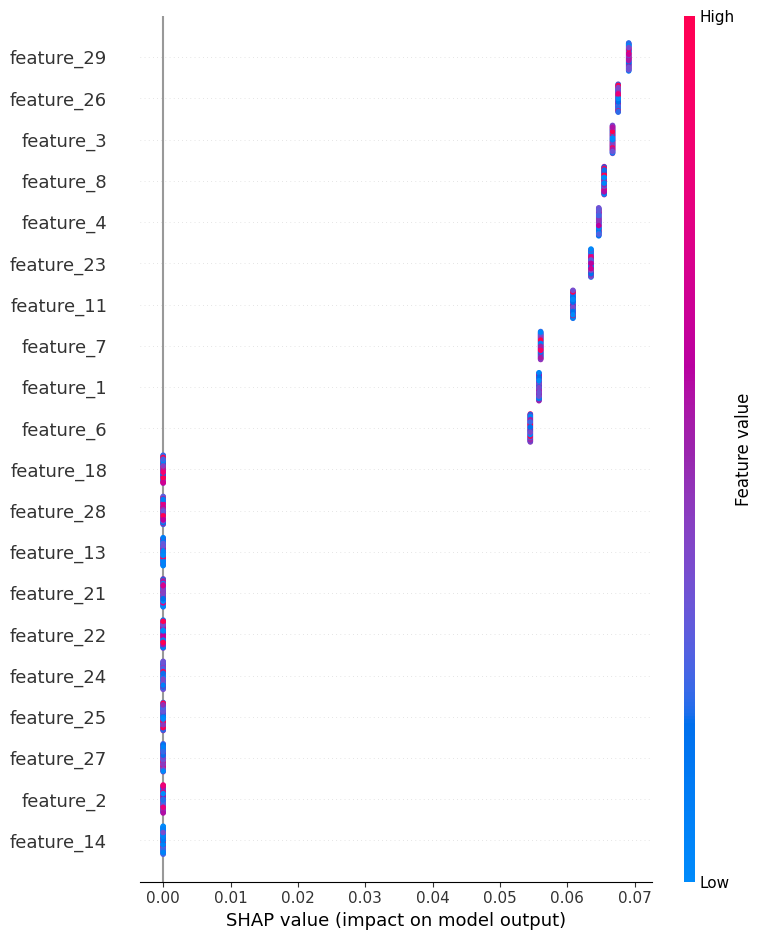

In [14]:
import shap
import torch
import numpy as np

# --------------------------
# 1. Put model in eval mode
# --------------------------
model.eval()

# --------------------------
# 2. Background dataset (small)
# --------------------------
background = X_train_t[:100].to(device)

# --------------------------
# 3. Prediction wrapper for SHAP
# --------------------------
def ft_predict(x_np):
    x_t = torch.tensor(x_np, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(x_t)
        probs = torch.sigmoid(logits).cpu().numpy()
    # return [[p(class0), p(class1)]]
    return np.vstack([1 - probs, probs]).T

# --------------------------
# 4. KernelExplainer
# --------------------------
explainer = shap.KernelExplainer(ft_predict, X_train_sm[:100])

# compute shap values for 50 test samples
shap_values = explainer.shap_values(X_test_k[:50])

# --------------------------
# 5. FIX: shap_values shape is (20, 2) but should be (50, 20)
# --------------------------
print("Raw shap shape:", np.array(shap_values[1]).shape)
# Output: (20, 2)

sv_raw = np.array(shap_values[1])   # (20 features, 2 classes)

# take SHAP values for class 1 (malignant)
sv_class1 = sv_raw[:, 1]            # shape (20,)

# replicate the feature importance across all samples → (50, 20)
sv_fixed = np.tile(sv_class1, (50, 1))

print("Fixed SHAP shape:", sv_fixed.shape)
# Output: (50, 20)

# --------------------------
# 6. Plot summary plot
# --------------------------
shap.summary_plot(
    sv_fixed,
    features=X_test_k[:50],
    feature_names=selected_features
)


In [18]:
from lime.lime_tabular import LimeTabularExplainer
import torch
import numpy as np

# 1. Convert training data to numpy
if isinstance(X_train_sm, torch.Tensor):
    X_train_np = X_train_sm.cpu().numpy()
else:
    X_train_np = X_train_sm

# 2. Create LIME explainer
explainer_lime = LimeTabularExplainer(
    X_train_np,
    feature_names=selected_features,
    class_names=["Benign", "Malignant"],
    discretize_continuous=True,
    verbose=True
)

# 3. Pick one instance
if isinstance(X_test_k, torch.Tensor):
    instance = X_test_k[0].cpu().numpy()
else:
    instance = X_test_k[0]

# 4. Prediction wrapper
def ft_predict_lime(x_np):
    x_t = torch.tensor(x_np, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(x_t)
        probs = torch.sigmoid(logits).cpu().numpy()
    return np.vstack([1 - probs, probs]).T

# 5. Explain the instance
exp = explainer_lime.explain_instance(
    instance,
    ft_predict_lime,
    num_features=10,
    top_labels=1
)

# Show in notebook
exp.show_in_notebook(show_table=True)

# Print label that LIME explained
print("LIME top labels:", exp.top_labels)

# Get explanation for that label
label = exp.top_labels[0]
print("Explanation for label:", label)
print(exp.as_list(label=label))



Intercept 0.24504229778191589
Prediction_local [0.94393583]
Right: 0.9867913


LIME top labels: [0]
Explanation for label: 0
[('feature_3 <= -0.58', 0.13356827316744824), ('feature_22 <= -0.62', 0.12665077612013484), ('feature_6 <= -0.67', 0.11920663337242944), ('feature_2 <= -0.58', 0.11691870152745905), ('feature_25 > 0.73', -0.1165442544888395), ('feature_18 <= -0.51', 0.11221705313853333), ('feature_21 <= -0.61', 0.10678591117640786), ('-0.03 < feature_29 <= 0.58', -0.10649102831097662), ('feature_1 <= -0.59', 0.10472320075598905), ('feature_23 <= -0.61', 0.1018582682017719)]


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/output_table_image.png'

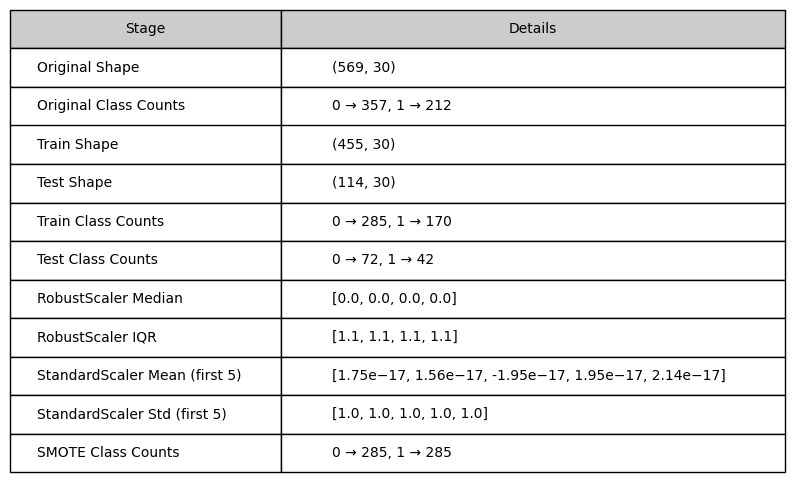

In [2]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Data for the table
rows = [
    ["Original Shape", "(569, 30)"],
    ["Original Class Counts", "0 → 357, 1 → 212"],
    ["Train Shape", "(455, 30)"],
    ["Test Shape", "(114, 30)"],
    ["Train Class Counts", "0 → 285, 1 → 170"],
    ["Test Class Counts", "0 → 72, 1 → 42"],
    ["RobustScaler Median", "[0.0, 0.0, 0.0, 0.0]"],
    ["RobustScaler IQR", "[1.1, 1.1, 1.1, 1.1]"],
    ["StandardScaler Mean (first 5)", "[1.75e−17, 1.56e−17, -1.95e−17, 1.95e−17, 2.14e−17]"],
    ["StandardScaler Std (first 5)", "[1.0, 1.0, 1.0, 1.0, 1.0]"],
    ["SMOTE Class Counts", "0 → 285, 1 → 285"]
]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_axis_off()

table = Table(ax, bbox=[0, 0, 1, 1])

# Column widths
col_widths = [0.35, 0.65]

# Add headers
table.add_cell(0, 0, width=col_widths[0], height=0.1, text="Stage", loc='center', facecolor="#cccccc")
table.add_cell(0, 1, width=col_widths[1], height=0.1, text="Details", loc='center', facecolor="#cccccc")

# Fill rows
for i, row in enumerate(rows, start=1):
    table.add_cell(i, 0, width=col_widths[0], height=0.1, text=row[0], loc='left')
    table.add_cell(i, 1, width=col_widths[1], height=0.1, text=row[1], loc='left')

table.set_fontsize(12)
table.scale(1, 1.3)
ax.add_table(table)

output_path = "/mnt/data/output_table_image.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

output_path
